# Detección de fraude en tarjetas de crédito

In [1]:
COLAB = True

In [132]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from IPython.display import clear_output

pd.options.display.max_columns = None

# Funciones de apoyo

In [3]:
def plot_roc(clases_reales, scores, clase_positiva):
  fpr, tpr, umbrales = roc_curve(clases_reales, scores, pos_label=clase_positiva)
  plt.figure(figsize=(12,3))
  plt.plot(fpr, tpr, ".-")
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.plot([0,1], [1,0])
  plt.show()
  plt.figure(figsize=(12,3))
  plt.plot(fpr, umbrales, ".-")
  plt.xlabel("FPR")
  plt.ylabel("Umbral")

def mi_precision_recall(clases_reales, scores, clase_positiva):
  precision, recall, umbrales = precision_recall_curve(clases_reales, scores,
                                                       pos_label=clase_positiva)
  plt.figure(figsize=(12,3))
  plt.plot(recall, precision, ".-")
  plt.xlabel("RECALL")
  plt.ylabel("PRECISION")
  plt.show()
  plt.figure(figsize=(12,3))
  plt.plot(recall[1:], umbrales, ".-")
  plt.xlabel("RECALL")
  plt.ylabel("Umbral")

def mis_costes(clases_reales, scores, clase_positiva=1,
               coste_FP=1, coste_FN=1):
  mis_umbrales = np.unique(scores)
  FPR = []
  TPR = []
  costes = []
  P = (clases_reales==clase_positiva).sum()
  N = len(clases_reales) - P
  #N = (clases_reales!=clase_positiva).sum()
  for umbral in tqdm(mis_umbrales):
    alarmas = scores>=umbral
    FP = (clases_reales[alarmas] != clase_positiva).sum()
    TP = (clases_reales[alarmas] == clase_positiva).sum()
    no_alarmas = scores<umbral
    FN = (clases_reales[no_alarmas] == clase_positiva).sum()
    FPR.append(FP/N)
    TPR.append(TP/P)
    costes.append(FP*coste_FP + FN*coste_FN)

  plt.plot(FPR, TPR, ".-")
  plt.title("Curva ROC")
  plt.show()

  i = np.argmin(costes)
  coste_minimo = costes[i]
  umbral_optimo = mis_umbrales[i]
  plt.plot(mis_umbrales, costes, ".-")
  plt.plot(umbral_optimo, coste_minimo, "or")
  plt.title("Curva Costes")
  plt.ylabel("COSTE")
  plt.xlabel("UMBRAL")

  return coste_minimo, umbral_optimo

def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

# Carga del dataset

In [4]:
!ls -la

total 16
drwxr-xr-x 1 root root 4096 Jul 10 13:24 .
drwxr-xr-x 1 root root 4096 Jul 12 14:32 ..
drwxr-xr-x 4 root root 4096 Jul 10 13:23 .config
drwxr-xr-x 1 root root 4096 Jul 10 13:24 sample_data


In [5]:
if COLAB:
    aux = "'https://drive.usercontent.google.com/download?id=1uSFC-iy_-_NkK-AEjoPMJI6ximN-jM5F&export=download&confirm=t&uuid=9699f0e2-e760-49fc-b12e-49f140095280'"
    print("wget {} -O ./creditcard.csv.zip".format(aux))
    !wget $aux -O ./creditcard.csv.zip
    !unzip -qq ./creditcard.csv.zip

wget 'https://drive.usercontent.google.com/download?id=1uSFC-iy_-_NkK-AEjoPMJI6ximN-jM5F&export=download&confirm=t&uuid=9699f0e2-e760-49fc-b12e-49f140095280' -O ./creditcard.csv.zip
--2024-07-12 14:33:15--  https://drive.usercontent.google.com/download?id=1uSFC-iy_-_NkK-AEjoPMJI6ximN-jM5F&export=download&confirm=t&uuid=9699f0e2-e760-49fc-b12e-49f140095280
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.179.132, 2607:f8b0:4004:c1f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.179.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44909937 (43M) [application/octet-stream]
Saving to: ‘./creditcard.csv.zip’

./creditcard.csv.zi 100%[===================>]  42.83M  53.5MB/s    in 0.8s    

2024-07-12 14:33:17 (53.5 MB/s) - ‘./creditcard.csv.zip’ saved [44909937/44909937]



In [6]:
df = pd.read_csv("creditcard.csv")

In [7]:
df.sample(10)

Time        V1        V2        V3        V4        V5        V6  \
161241  114021.0  1.709204 -0.679342 -1.644123  0.225038  0.677169  0.972919   
204250  135190.0 -0.509517  0.676125  1.180810 -0.765833  0.112744 -0.369242   
233761  147693.0 -2.209057  1.644408 -1.037254 -0.500089 -0.530506 -1.133998   
226004  144472.0 -1.045307  0.747742 -1.070656 -0.718484  1.911217 -0.955969   
149864   92087.0 -1.451238  3.254195 -4.882234  2.500684  0.049397 -2.453242   
256294  157626.0  1.899002  0.013184 -1.522552  0.843319  1.115245  0.999412   
47374    43190.0 -1.018390  0.582161  2.346026  1.646752 -0.263371  0.207166   
191926  129459.0  0.178918  1.040035 -0.758166  1.267910 -0.173155 -0.649237   
277734  167825.0  2.071738 -0.116211 -1.927280  0.332301  0.474084 -0.997260   
8613     11626.0 -1.641284 -0.193170  2.179049 -0.907968  0.931056 -0.706986   

              V7        V8        V9       V10       V11       V12       V13  \
161241 -0.089388  0.230834  0.310069  0.164315  0.921039  0.867745 -0.069275   
204250 -0.371157 -1.528803 -0.011047 -0.577047  0.673582  0.399107 -1.326171   
233761  0.186861  1.032905 -0.017038 -1.891970 -1.148239  0.031157 -0.725941   
226004  1.117337  0.227218 -1.359470 -0.627770  0.051907 -0.104569 -1.277806   
149864 -1.467971  0.681112 -1.101456 -4.531485  2.569562 -6.351587  1.656405   
256294  0.009690  0.203914 -0.093555  0.349560  1.079412  1.281108  0.726853   
47374   0.299493  0.307744 -0.497418  0.162940  0.384152 -0.217589 -1.736834   
191926  1.340655 -0.534469 -0.301163 -0.168626 -0.303448 -0.408904  0.239159   
277734  0.544702 -0.434884  0.416335  0.093607 -1.494580  0.147090  0.052191   
8613   -0.296443  0.138977  0.989788 -0.994652  2.362377 -2.022003  1.094220   

             V14       V15       V16       V17       V18       V19       V20  \
161241  0.598322  0.505886 -0.534565 -0.080619 -0.763288 -0.880613 -0.055110   
204250  0.586598 -0.804229  0.586390 -0.682334  0.123662 -0.701124 -0.557684   
233761 -0.590765 -0.461249  0.297920  1.575092  0.247005 -0.083744 -0.405055   
226004  1.472106 -1.156619 -0.387749 -0.294028  0.217194  0.273125 -0.125048   
149864 -3.823650 -1.127617 -3.427731 -3.223043 -1.214808 -0.021311 -0.043739   
256294  0.601707  0.556179 -0.561759 -0.316210 -0.735086 -1.160698 -0.278656   
47374   0.006471 -1.629187  0.823905 -0.723901  0.567027 -1.198147 -0.317275   
191926 -0.709336  2.009267 -0.870431  1.259961  0.995590  2.208236  0.042512   
277734  0.368655 -0.398068 -0.365986 -0.323696 -0.622038  0.447530 -0.143762   
8613    1.713207 -0.390338  0.457301  0.205030  0.028077 -0.685623 -0.277039   

             V21       V22       V23       V24       V25       V26       V27  \
161241  0.446703  1.274799 -0.125224 -1.551478 -0.022897  0.679899 -0.037476   
204250  1.434807 -0.952506 -0.777007  0.076185  1.554082  0.358344  0.047041   
233761 -0.081338 -0.481093 -0.150253 -0.136444  0.123212 -0.100403 -0.392792   
226004  0.436260  0.905542 -0.620906  0.372573  0.820253  0.698075 -0.135929   
149864  0.742459  0.783571 -0.207588 -0.296522  0.487173 -0.264616 -0.060481   
256294  0.358859  1.272640 -0.025789 -1.603372  0.182325 -0.317307  0.051788   
47374   0.224497  0.619938 -0.195907  0.511458 -0.169540 -0.077157  0.028990   
191926  0.364682  1.416159  0.033448  0.027080 -1.162817  0.117337  0.194698   
277734 -0.059381 -0.025209 -0.038731 -0.589959  0.260134  0.597767 -0.103718   
8613   -0.184269 -0.381811 -0.288193  0.010670 -0.044667  0.792194 -0.084765   

             V28  Amount  Class  
161241 -0.073129  122.00      0  
204250  0.125729   12.95      0  
233761 -0.011498   63.22      0  
226004 -0.079822    0.00      0  
149864  0.188632    1.00      0  
256294 -0.076644    7.99      0  
47374   0.107527   69.35      0  
191926  0.248285  144.95      0  
277734 -0.077713   39.09      0  
8613    0.000530   20.64      0

In [10]:
df[:20]

Time        V1        V2        V3        V4        V5        V6  \
0    0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1    0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2    1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3    1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4    2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   
5    2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728   
6    4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708   
7    7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118   
8    7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818   
9    9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761   
10  10.0  1.449044 -1.176339  0.913860 -1.375667 -1.971383 -0.629152   
11  10.0  0.384978  0.616109 -0.874300 -0.094019  2.924584  3.317027   
12  10.0  1.249999 -1.221637  0.383930 -1.234899 -1.485419 -0.753230   
13  11.0  1.069374  0.287722  0.828613  2.712520 -0.178398  0.337544   
14  12.0 -2.791855 -0.327771  1.641750  1.767473 -0.136588  0.807596   
15  12.0 -0.752417  0.345485  2.057323 -1.468643 -1.158394 -0.077850   
16  12.0  1.103215 -0.040296  1.267332  1.289091 -0.735997  0.288069   
17  13.0 -0.436905  0.918966  0.924591 -0.727219  0.915679 -0.127867   
18  14.0 -5.401258 -5.450148  1.186305  1.736239  3.049106 -1.763406   
19  15.0  1.492936 -1.029346  0.454795 -1.438026 -1.555434 -0.720961   

          V7        V8        V9       V10       V11       V12       V13  \
0   0.239599  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390   
1  -0.078803  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095   
2   0.791461  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293   
3   0.237609  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757   
4   0.592941 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852   
5   0.476201  0.260314 -0.568671 -0.371407  1.341262  0.359894 -0.358091   
6  -0.005159  0.081213  0.464960 -0.099254 -1.416907 -0.153826 -0.751063   
7   1.120631 -3.807864  0.615375  1.249376 -0.619468  0.291474  1.757964   
8   0.370145  0.851084 -0.392048 -0.410430 -0.705117 -0.110452 -0.286254   
9   0.651583  0.069539 -0.736727 -0.366846  1.017614  0.836390  1.006844   
10 -1.423236  0.048456 -1.720408  1.626659  1.199644 -0.671440 -0.513947   
11  0.470455  0.538247 -0.558895  0.309755 -0.259116 -0.326143 -0.090047   
12 -0.689405 -0.227487 -2.094011  1.323729  0.227666 -0.242682  1.205417   
13 -0.096717  0.115982 -0.221083  0.460230 -0.773657  0.323387 -0.011076   
14 -0.422911 -1.907107  0.755713  1.151087  0.844555  0.792944  0.370448   
15 -0.608581  0.003603 -0.436167  0.747731 -0.793981 -0.770407  1.047627   
16 -0.586057  0.189380  0.782333 -0.267975 -0.450311  0.936708  0.708380   
17  0.707642  0.087962 -0.665271 -0.737980  0.324098  0.277192  0.252624   
18 -1.559738  0.160842  1.233090  0.345173  0.917230  0.970117 -0.266568   
19 -1.080664 -0.053127 -1.978682  1.638076  1.077542 -0.632047 -0.416957   

         V14       V15       V16       V17       V18       V19       V20  \
0  -0.311169  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412   
1  -0.143772  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083   
2  -0.165946  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980   
3  -0.287924 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038   
4  -1.119670  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542   
5  -0.137134  0.517617  0.401726 -0.058133  0.068653 -0.033194  0.084968   
6   0.167372  0.050144 -0.443587  0.002821 -0.611987 -0.045575 -0.219633   
7  -1.323865  0.686133 -0.076127 -1.222127 -0.358222  0.324505 -0.156742   
8   0.074355 -0.328783 -0.210077 -0.499768  0.118765  0.570328  0.052736   
9  -0.443523  0.150219  0.739453 -0.540980  0.476677  0.451773  0.203711   
10 -0.095045  0.230930  0.031967  0.253415  0.854344 -0.22

In [ ]:
df.describe().T[["count", "mean", "std", "min", "max"]]

In [ ]:
df.sort_values("Amount", ascending=False)[:20]

In [12]:
2*24*60*60

172800

* Variable time: la eliminamos, solo tenemos 2 días de datos
* Variables Vi: vienen de PCA. No las normalizamos, ya que su varianza (o la std) indica la importancia.
* Variable Amount: la dividimos entre 125 para que tenga una std más o menos igual que V1

In [16]:
df.drop("Time", axis=1, inplace=True)
df["Amount"] = df["Amount"] / 125

In [ ]:
df.describe().T[["count", "mean", "std", "min", "max"]]

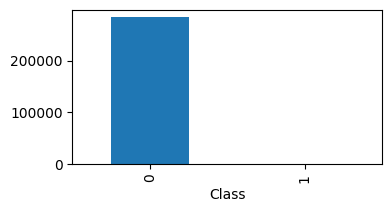

In [24]:
df["Class"].value_counts().plot(kind="bar", figsize=(4,2));

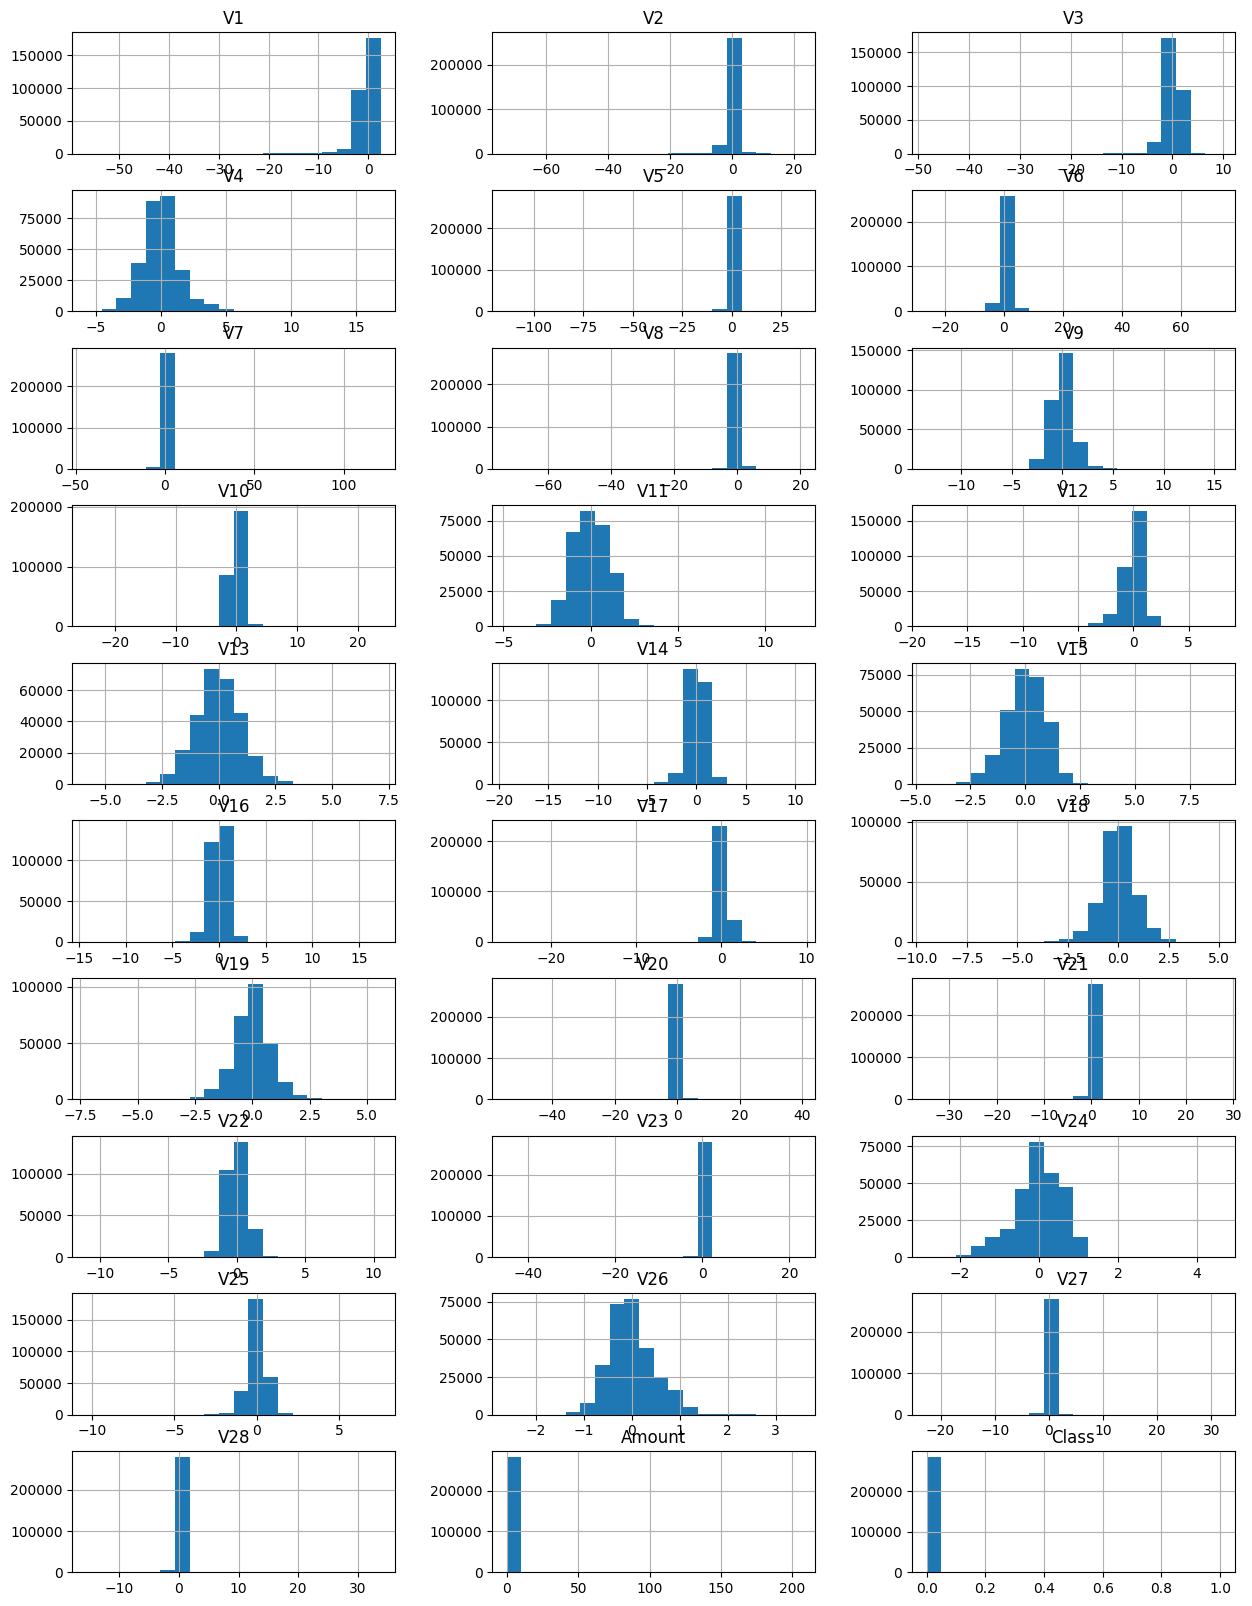

In [37]:
df.hist(layout=(10,3), figsize=(15,20), bins=20);

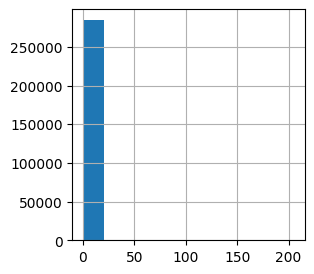

In [163]:
df["Amount"].hist(figsize=(3,3));

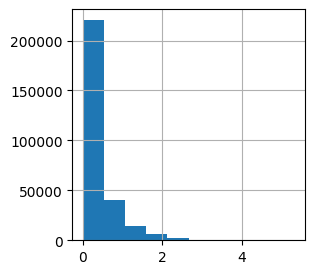

In [164]:
df["Amount"].apply(np.log1p).hist(figsize=(3,3));

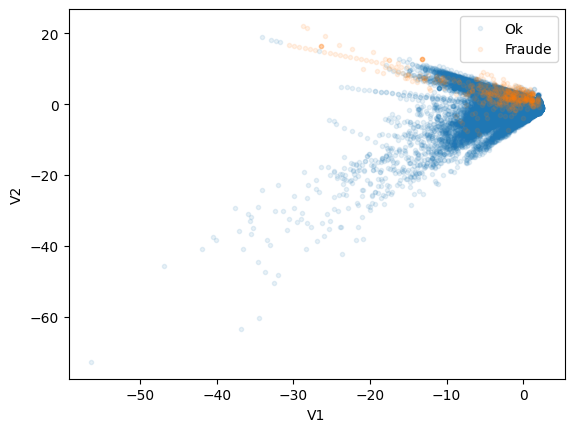

In [45]:
plt.plot(df.loc[df["Class"]==0, "V1"], df.loc[df["Class"]==0, "V2"], ".", alpha=0.1, label="Ok")
plt.plot(df.loc[df["Class"]==1, "V1"], df.loc[df["Class"]==1, "V2"], ".", alpha=0.1, label="Fraude")
plt.xlabel("V1")
plt.ylabel("V2")
plt.legend();

In [ ]:
# Separo la base de datos en ok y fraude

df_ok = df[df["Class"]==0]
df_ko = df[df["Class"]==1]

# Ahora separo en training y test:
from sklearn.model_selection import train_test_split

df_ok_tr, df_ok_te = train_test_split(df_ok, test_size=0.3,
                                      random_state=1)
df_ok_tr[:5]

In [29]:
len(df_ok_te) + len(df_ko)

85787

In [30]:
df_te = pd.concat([df_ok_te, df_ko])
df_te.shape

(85787, 30)

# Autoencoder base: autoencoder lineal

In [65]:
from sklearn.decomposition import PCA

df_prueba = pd.DataFrame(np.random.rand(200,2), columns=["x1", "x2"])
df_prueba["x1"] = 10*df_prueba["x1"]
df_prueba["x3"] = df_prueba["x1"]
df_prueba["x4"] = df_prueba["x1"] + df_prueba["x2"]
df_prueba[:3]

x1        x2        x3         x4
0  8.266237  0.612094  8.266237   8.878331
1  7.017004  0.884320  7.017004   7.901324
2  9.926741  0.918260  9.926741  10.845001

In [66]:
pca = PCA(n_components=1)
pca.fit(df_prueba)
X_pca = pca.transform(df_prueba)
X_pca[:3]

array([[-5.27716925],
       [-3.2731984 ],
       [-8.33279053]])

In [67]:
pca.inverse_transform(X_pca)[:3]

array([[ 8.30133796,  0.50846722,  8.30133796,  8.80980519],
       [ 7.14811751,  0.49724005,  7.14811751,  7.64535756],
       [10.05974925,  0.52558623, 10.05974925, 10.58533548]])

In [69]:
X_tr = df_ok_tr.drop("Class", axis=1) # todos son ok

In [139]:
pca = PCA(n_components=3)
pca.fit(X_tr)

PCA(n_components=3)

In [140]:
def encoder(X):
  return pca.transform(X)

def decoder(X):
  return pca.inverse_transform(X)

In [141]:
# Pasamos el autoencoder en test:

y_te = df_te["Class"]
X_te = df_te.drop("Class", axis=1).values

salida_ae = decoder(encoder(X_te))
salida_ae.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


(85787, 29)

In [142]:
X_te.shape

(85787, 29)

In [143]:
score_anomalia = ((salida_ae - X_te)**2).mean(axis=1)
score_anomalia.shape

(85787,)

In [144]:
df_resultados_te = pd.DataFrame({"score":score_anomalia, "Class":y_te})
df_resultados_te.sort_values("score", ascending=False)[:20]

score  Class
65423   308.940771      0
154684  242.645522      1
154587  225.390096      1
39769   177.097166      0
154371  171.473766      1
154234  137.573846      1
151006  126.454275      1
151007  126.454275      1
151008  126.454275      1
151009  126.454275      1
153835  109.961974      1
102441  106.459922      1
102442  106.459922      1
102443  106.459922      1
102444  106.459922      1
102445  106.459922      1
102446  106.459922      1
153823  105.696872      1
43432    95.237045      0
145022   93.722078      0

# Representación de las anomalías predichas para un umbral dado

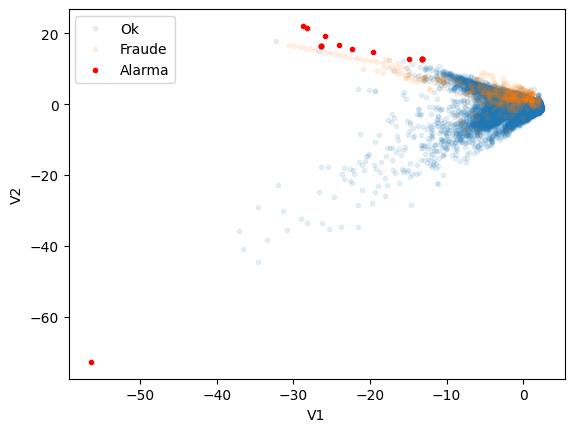

In [156]:
umbral = 100
alarmas = (score_anomalia > umbral)

plt.plot(df_te.loc[df_te["Class"]==0, "V1"], df_te.loc[df_te["Class"]==0, "V2"], ".", alpha=0.1, label="Ok")
plt.plot(df_te.loc[df_te["Class"]==1, "V1"], df_te.loc[df_te["Class"]==1, "V2"], ".", alpha=0.1, label="Fraude")
plt.plot(df_te.loc[alarmas, "V1"], df_te.loc[alarmas, "V2"], ".r", label="Alarma")
plt.xlabel("V1")
plt.ylabel("V2")
plt.legend();

# Métricas en test del autoencoder y elección de umbral óptimo

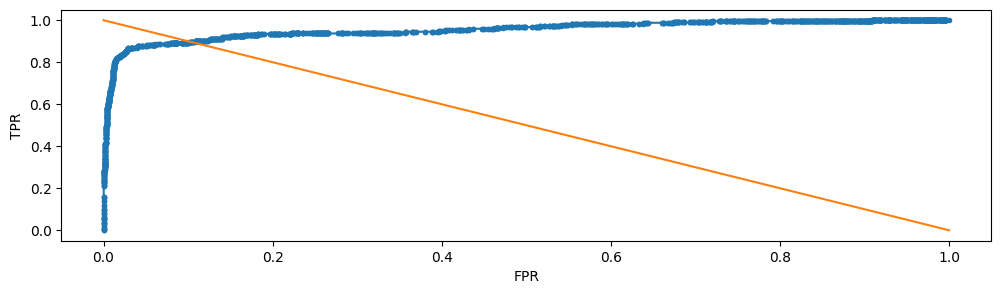

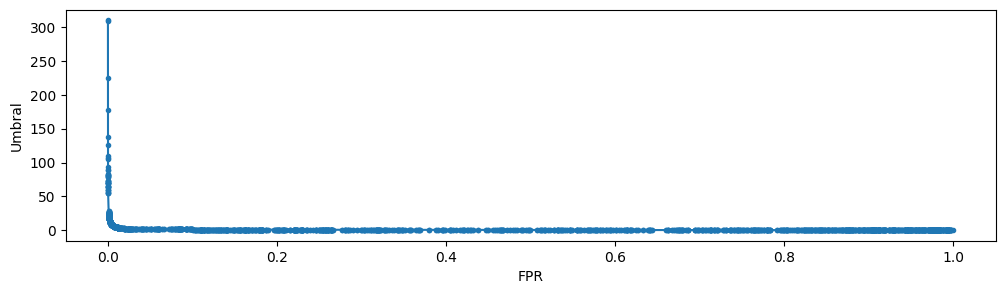

In [145]:
plot_roc(y_te, score_anomalia, clase_positiva=1)

In [146]:
X_te.shape

(85787, 29)

In [147]:
inds = np.random.permutation(len(X_te))[:10000]
inds[:10]

array([30023, 74220,  1644, 85772, 85456, 43118, 35022, 18499, 50541,
       64513])

100%|██████████| 9961/9961 [00:02<00:00, 4721.91it/s]


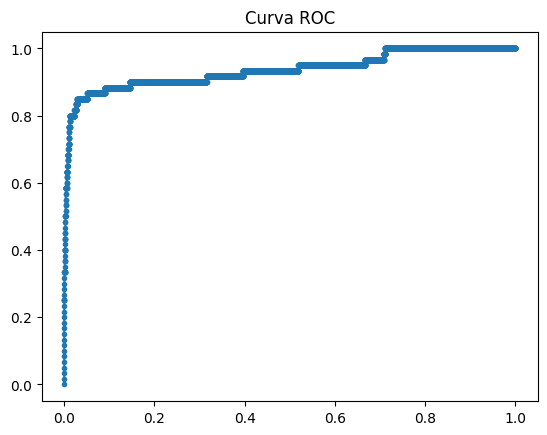

(245, 3.50785814930992)

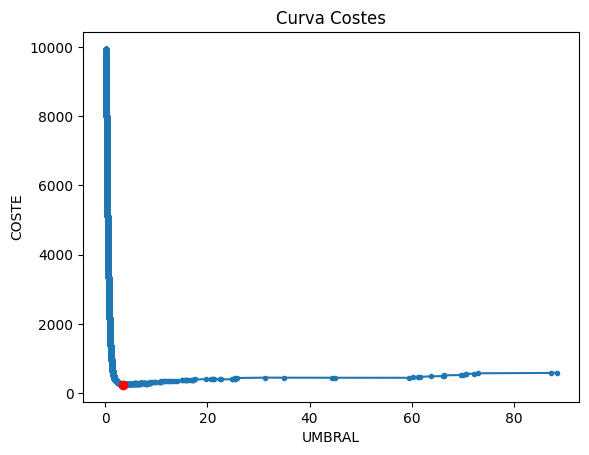

In [148]:
mis_costes(clases_reales=y_te.values[inds], scores=score_anomalia[inds], clase_positiva=1, coste_FP=1, coste_FN=10)

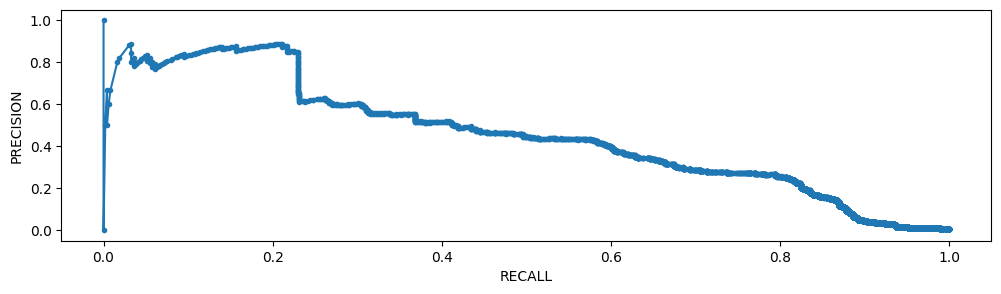

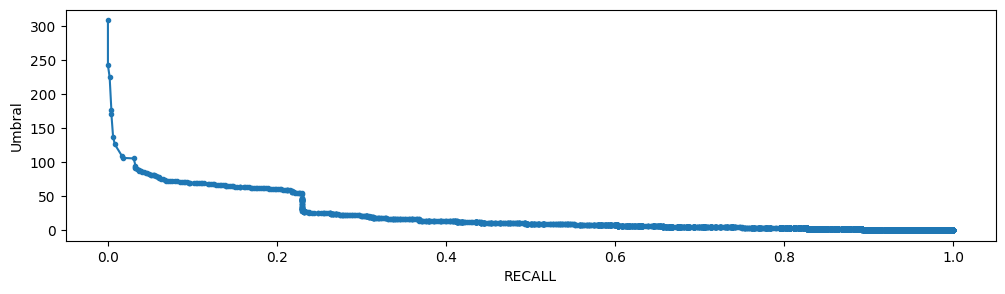

In [149]:
mi_precision_recall(clases_reales=y_te, scores=score_anomalia, clase_positiva=1)

In [ ]:
umbral = 80
alarmas = (score_anomalia2 > umbral)

plt.plot(df_te.loc[df_te["Class"]==0, "V1"], df_te.loc[df_te["Class"]==0, "V2"], ".", alpha=0.1, label="Ok")
plt.plot(df_te.loc[df_te["Class"]==1, "V1"], df_te.loc[df_te["Class"]==1, "V2"], ".", alpha=0.1, label="Fraude")
plt.plot(df_te.loc[alarmas, "V1"], df_te.loc[alarmas, "V2"], ".r", label="Alarma")
plt.xlabel("V1")
plt.ylabel("V2")
plt.legend();

# Autoencoder denso

In [126]:
import keras

bottleneck = 3
n_neuronas_capa1 = 10

nvariables = X_tr.shape[1] # número de columnas sin contar la clase

encoder = keras.Sequential(
    [
        keras.layers.Dense(units=n_neuronas_capa1, activation="relu",
                           input_shape=(nvariables,)),
        keras.layers.Dense(units=bottleneck, activation="relu")
    ]
)

decoder = keras.Sequential(
    [
        keras.layers.Dense(units=n_neuronas_capa1, activation="relu",
                           input_shape=(bottleneck,)),
        keras.layers.Dense(units=nvariables)
    ]
)

model = keras.Sequential([encoder, decoder])
model.compile(loss="mse", optimizer="adam", metrics="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 3)                 333       
                                                                 
 sequential_1 (Sequential)   (None, 29)                359       
                                                                 
Total params: 692 (2.70 KB)
Trainable params: 692 (2.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [127]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                300       
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 333 (1.30 KB)
Trainable params: 333 (1.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [128]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                40        
                                                                 
 dense_3 (Dense)             (None, 29)                319       
                                                                 
Total params: 359 (1.40 KB)
Trainable params: 359 (1.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [129]:
epochs = 20

# Los datos de entrenamiento los vuelvo a partir en training y validación:
X_tr2, X_val = train_test_split(X_tr, test_size=0.3, random_state=1)

In [130]:
evolucion_mse_tr = []
evolucion_mse_va = []
modelpath = "best_model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(modelpath, monitor="val_mse", verbose=2,
                                             save_best_only=True, mode="min")

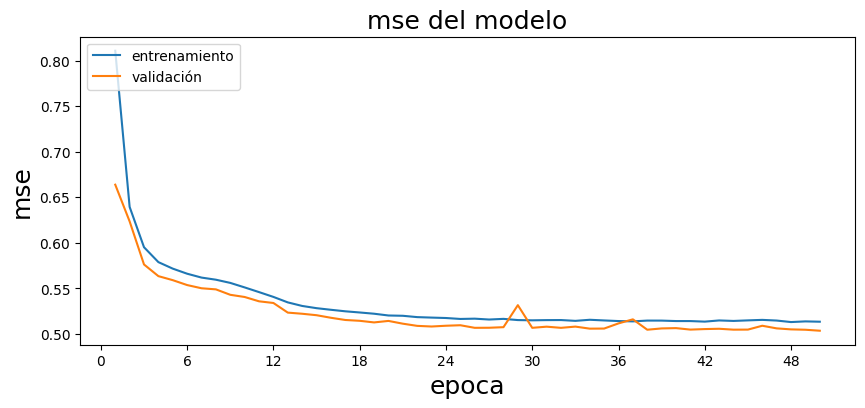

 593/4354 [===>..........................] - ETA: 13s - loss: 0.5393 - mse: 0.5393

KeyboardInterrupt: 

In [133]:
for epoca in range(epochs):
  h = model.fit(X_tr2, X_tr2, epochs=1, callbacks=[checkpoint],
                verbose=1, validation_data=(X_val, X_val))
  evolucion_mse_tr.append(h.history["mse"][0])
  evolucion_mse_va.append(h.history["val_mse"][0])
  clear_output()
  grafica_entrenamiento(evolucion_mse_tr, evolucion_mse_va)

In [134]:
salida_ae2 = model.predict(X_te)
salida_ae2.shape

2681/2681 [==============================] - 7s 3ms/step


(85787, 29)

In [135]:
score_anomalia2 = ((salida_ae2 - X_te)**2).mean(axis=1)
df_resultados_te2 = pd.DataFrame({"score":score_anomalia2, "Class":y_te})
df_resultados_te2.sort_values("score", ascending=False)[:20]

score  Class
154684  109.517001      1
154587  106.065188      1
151008   96.953842      1
151006   96.953842      1
151009   96.953842      1
151007   96.953842      1
154371   95.722869      1
227921   92.390054      0
154234   86.400174      1
153835   82.885422      1
153823   81.189381      1
10690    78.774310      1
39769    78.633627      0
233904   76.384075      0
44270    75.554912      1
152295   75.233699      1
152223   74.476379      1
44223    73.950979      1
151519   73.360557      1
151462   73.162573      1

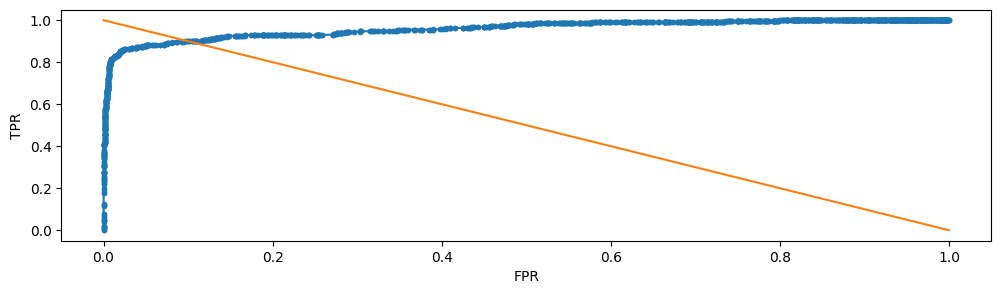

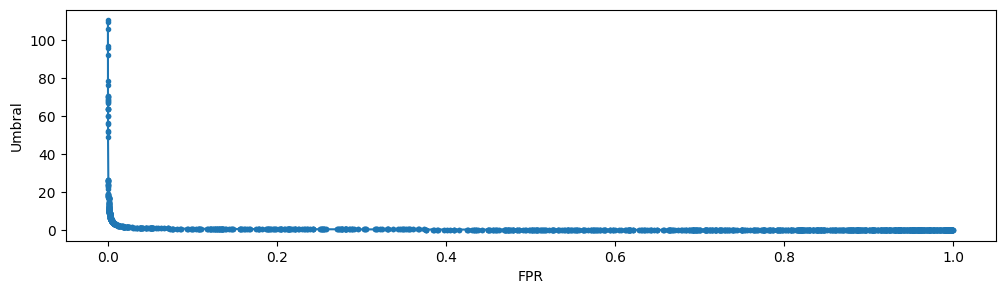

In [136]:
plot_roc(y_te, score_anomalia2, clase_positiva=1)

100%|██████████| 9957/9957 [00:04<00:00, 2431.89it/s]


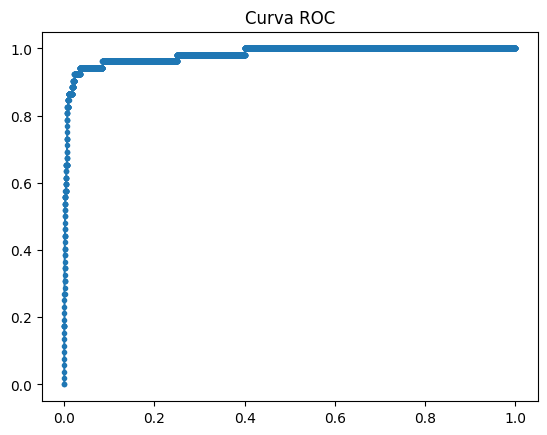

(160, 3.961684392409337)

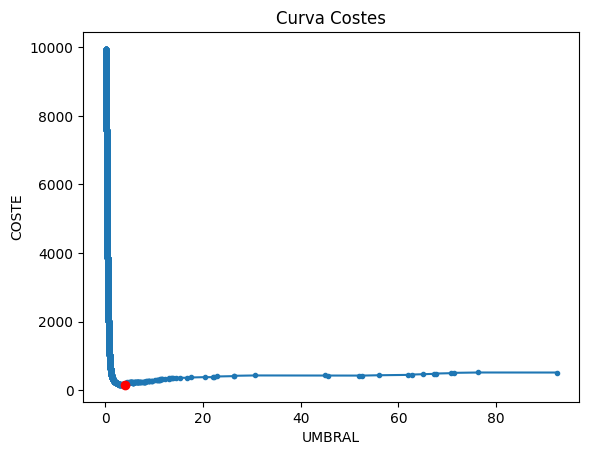

In [137]:
mis_costes(clases_reales=y_te.values[inds], scores=score_anomalia2[inds], clase_positiva=1, coste_FP=1, coste_FN=10)

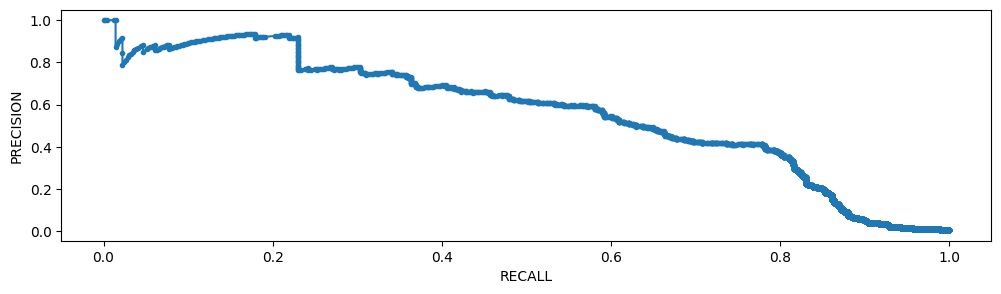

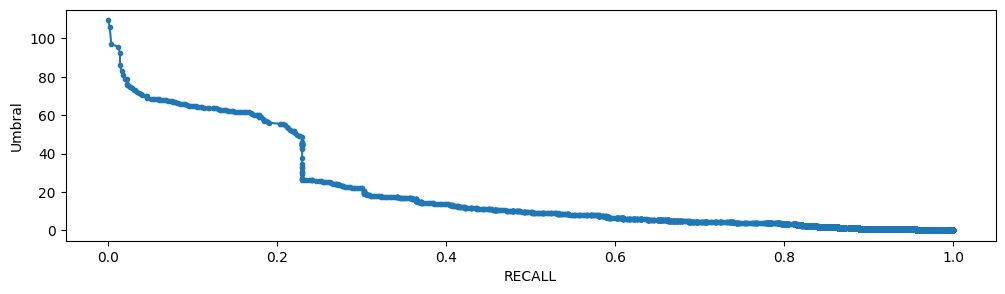

In [138]:
mi_precision_recall(clases_reales=y_te, scores=score_anomalia2, clase_positiva=1)

# Representación de las anomalías predichas para un umbral dado

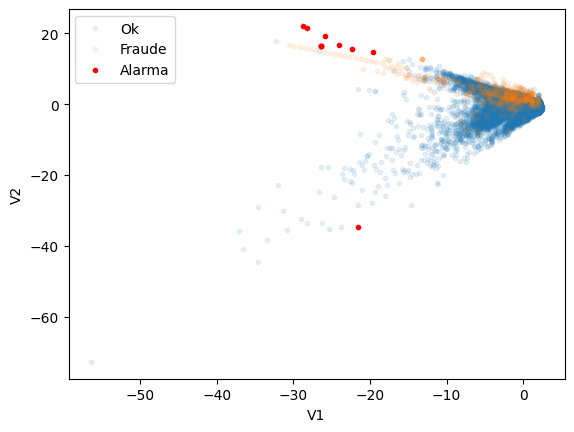

In [155]:
umbral = 80
alarmas = (score_anomalia2 > umbral)

plt.plot(df_te.loc[df_te["Class"]==0, "V1"], df_te.loc[df_te["Class"]==0, "V2"], ".", alpha=0.1, label="Ok")
plt.plot(df_te.loc[df_te["Class"]==1, "V1"], df_te.loc[df_te["Class"]==1, "V2"], ".", alpha=0.1, label="Fraude")
plt.plot(df_te.loc[alarmas, "V1"], df_te.loc[alarmas, "V2"], ".r", label="Alarma")
plt.xlabel("V1")
plt.ylabel("V2")
plt.legend();